In [3]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

images_dir = r"D:\RESEARCH_WORK\Teeth_Segmentation_Project\Dataset\Merged_dataset\segmentation_dataset"
masks_dir = r"D:\RESEARCH_WORK\Teeth_Segmentation_Project\Dataset\Merged_dataset\segmentation_masks"


# Load images and masks
def load_images_and_masks(image_dir, mask_dir, img_size=(224, 224)):
    images = []
    masks = []
    for file in os.listdir(image_dir):
        if file.endswith(".jpg") or file.endswith(".png"):
            img_path = os.path.join(image_dir, file)
            mask_path = os.path.join(mask_dir, file.replace(".jpg", ".png"))
            
            # Load and resize image and mask
            image = cv2.imread(img_path)
            image = cv2.resize(image, img_size) / 255.0
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
            masks.append(mask)
            images.append(image)
    
    return np.array(images), np.array(masks)

# Prepare dataset
X, y = load_images_and_masks(images_dir, masks_dir)
y = to_categorical(y, num_classes=3)  # Convert masks to one-hot encoding (3 classes)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a U-Net model
def build_unet(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(3, (1, 1), activation='softmax')(c5)  # 3 classes: background, tooth, nerve
    return Model(inputs, outputs)

# Compile and train the model
model = build_unet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 78s 9s/step - accuracy: 0.9819 - loss: 0.6455 - val_accuracy: 0.9914 - val_loss: 0.1745
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step - accuracy: 0.9897 - loss: 0.1542 - val_accuracy: 0.9914 - val_loss: 0.0946
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step - accuracy: 0.9898 - loss: 0.1003 - val_accuracy: 0.9914 - val_loss: 0.0715
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 9s/step - accuracy: 0.9897 - loss: 0.0774 - val_accuracy: 0.9914 - val_loss: 0.0498
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 78s 10s/step - accuracy: 0.9887 - loss: 0.0627 - val_accuracy: 0.9914 - val_loss: 0.0454
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 9s/step - accuracy: 0.9896 - loss: 0.0521 - val_accuracy: 0.9914 - val_loss: 0.0537
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 77s 10s/step - accuracy: 0.9899 - loss: 0.0580 - val_accuracy: 0.9914 - val_loss: 0.0463
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 77s 9s/step - accuracy: 0.9903 - loss: 0.0510 - val_accuracy: 0.9914 - val_loss: 0.0564
Epoch 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
IoU for each class: [0.99139237 0.                nan]
Mean IoU: 0.4956961839153765
Pixel Accuracy: 0.991392367830753


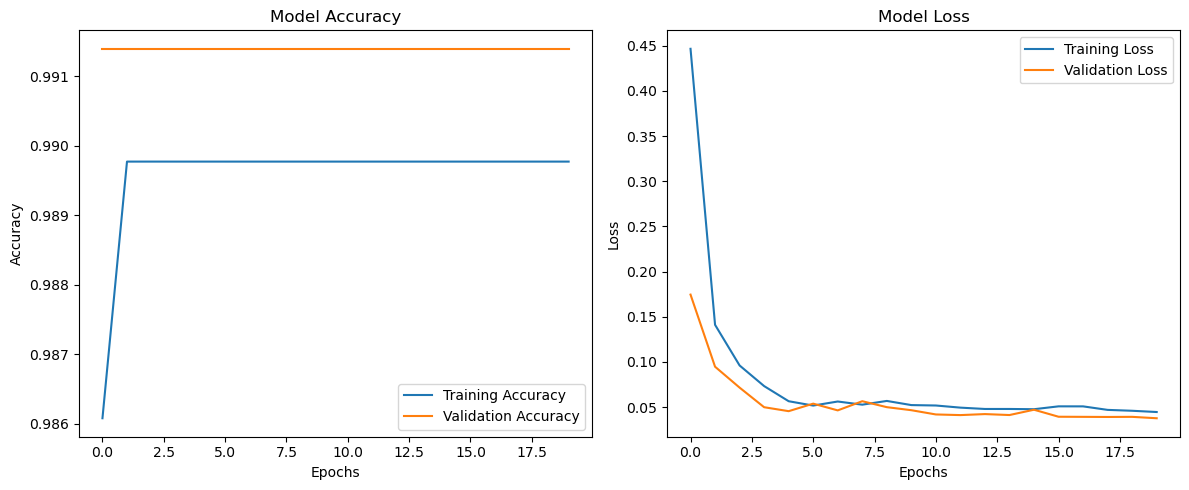

In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to calculate IoU for each class
def calculate_iou(y_true, y_pred, num_classes=3):
    iou_per_class = []
    for cls in range(num_classes):
        true_mask = (y_true == cls)
        pred_mask = (y_pred == cls)
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()
        if union == 0:
            iou_per_class.append(np.nan)  # Handle edge case where union is 0
        else:
            iou_per_class.append(intersection / union)
    return np.array(iou_per_class)

# Function to evaluate the model
def evaluate_model(model, X_val, y_val, num_classes=3):
    y_pred = model.predict(X_val, batch_size=16)
    y_pred = np.argmax(y_pred, axis=-1)  # Get the predicted class for each pixel
    y_true = np.argmax(y_val, axis=-1)  # Get the ground truth class for each pixel

    # Flatten arrays for evaluation
    y_pred_flat = y_pred.flatten()
    y_true_flat = y_true.flatten()

    # Calculate IoU
    iou_per_class = calculate_iou(y_true_flat, y_pred_flat, num_classes)
    mean_iou = np.nanmean(iou_per_class)

    print("IoU for each class:", iou_per_class)
    print("Mean IoU:", mean_iou)

    # Calculate pixel accuracy
    pixel_accuracy = (y_true_flat == y_pred_flat).mean()
    print("Pixel Accuracy:", pixel_accuracy)

    return iou_per_class, mean_iou, pixel_accuracy

# Evaluate the model
iou_per_class, mean_iou, pixel_accuracy = evaluate_model(model, X_val, y_val)

# Plot training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)
